In [164]:
import sys
import os
import re
import numpy as np
import torch
from torch.multiprocessing import Process, set_start_method
from functools import partial
from utils import record_stats, display_stats, distribute
from pathlib import Path 


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
n_cpu = 16
n_instance = 50
nodesels = [ 'estimate_dummy', 'expert_dummy', 'gnn_dummy_nprimal=2', 'svm_dummy_nprimal=2']
problem = 'FCMCNF'
normalize = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
verbose = True
on_log = False
default = True
delete = False

if delete:
    try:
        import shutil
        shutil.rmtree(os.path.join(os.path.abspath(''), 
                                       f'stats/{problem}'))
    except:
        ''



instances = list(Path(os.path.join(os.path.abspath(''), 
                                   f"./problem_generation/data/{problem}/test")).glob("*.lp"))
if n_instance == -1 :
    n_instance = len(instances)

import random
random.shuffle(instances)
instances = instances[:n_instance]

print("Evaluation")
print(f"  Problem:                    {problem}")
print(f"  n_instance/problem:         {len(instances)}")
print(f"  Nodeselectors evaluated:    {','.join( ['default' if default else '' ] + nodesels)}")
print(f"  Device for GNN inference:   {device}")
print(f"  Normalize features:         {normalize}")
print("----------------")




Evaluation
  Problem:                    FCMCNF
  n_instance/problem:         50
  Nodeselectors evaluated:    default,estimate_dummy,expert_dummy,gnn_dummy_nprimal=2,svm_dummy_nprimal=2
  Device for GNN inference:   cuda
  Normalize features:         True
----------------


In [170]:
#Run benchmarks

processes = [  Process(name=f"worker {p}", 
                                target=partial(record_stats,
                                                nodesels=nodesels,
                                                instances=instances[p1:p2], 
                                                problem=problem,
                                                device=torch.device(device),
                                                normalize=normalize,
                                                verbose=verbose,
                                                default=default))
                for p,(p1,p2) in enumerate(distribute(n_instance, n_cpu)) ]  


try:
    set_start_method('spawn')
except RuntimeError:
    ''

a = list(map(lambda p: p.start(), processes)) #run processes
b = list(map(lambda p: p.join(), processes)) #join processes


------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_30.10.lp
   |----Nodesel: gnn_dummy_nprimal=2
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_30.10.lp
   |----Nodesel: svm_dummy_nprimal=2
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_74.79.lp
   |----Nodesel: gnn_dummy_nprimal=2
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_74.79.lp
   |----Nodesel: svm_dummy_nprimal=2
----------------------------

------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_23.36.lp
   |----Nodesel: gnn_dummy_nprimal=2
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_23.36.lp
   |----Nodesel: svm_dummy_nprimal=2
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_91.74.lp
   |----Nodesel: gnn_dummy_nprimal=2
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_91.74.lp
   |----Nodesel: svm_dummy_nprimal=2
----------------------------

Statistics on FCMCNF for problem size in [20, 20]
  default 
      Mean over n=50 instances : 
        |- B&B Tree Size   :  349
        |- Solving Time    :  31.08
-------------------------------------------------
  estimate_dummy 
      Mean over n=50 instances : 
        |- B&B Tree Size   :  340
        |- Solving Time    :  29.36
        |- nodecomp calls  :  2756
        |- nodesel calls   :  365
-------------------------------------------------
  expert_dummy 
      Mean over n=50 instances : 
        |- B&B Tree Size   :  176
        |- Solving Time    :  22.11
        |- nodecomp calls  :  1041
           |---   inference nodecomp calls:      36
        |- nodesel calls   :  178
-------------------------------------------------
  gnn_dummy_nprimal=2 
      Mean over n=50 instances : 
        |- B&B Tree Size   :  271
        |- Presolving A,b,c Feature Extraction Time :  
           |---   Init. Solver to CPU:           21.07
           |---   Init. CPU to GPU   :           0.

0

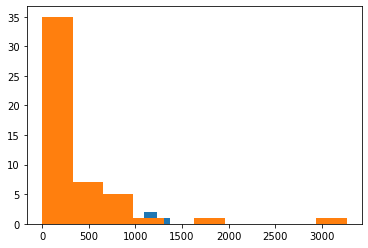

In [173]:
#print results
%reload_ext autoreload

min_n = min([ int( str(instance).split('=')[1].split('_')[0] )  for instance in instances ] )
max_n = max([ int( str(instance).split('=')[1].split('_')[0] )  for instance in instances ] )

nnode_means = display_stats(problem, nodesels, instances, min_n, max_n, default=default)


#print(nnode_means)

from matplotlib.pyplot import hist
hist(nnode_means['gnn_dummy_nprimal=2'].values())
hist(nnode_means['estimate_dummy'].values())


ins_to_delete = []
for ins in instances:
    instance = str(ins)
    try:
        if nnode_means['estimate_dummy'][instance] < 0:
            ins_to_delete.append(instance)
    except:
        ''
len(ins_to_delete)

In [156]:
#delete unsolved instances or bad instances
        

for nodesel in nodesels:
    for ins in instances:
        instance = str(ins)
        name = instance.split('/')[-1].split('.lp')[0]
        if not os.path.isfile(f'stats/{problem}/{nodesel}/{name}.csv') or instance in ins_to_delete:
            try:
                print(f'deleting instance {instance}')
                os.remove(instance)
                os.remove(instance.replace('.lp', '.sol'))
            except:
                print('instance already deleted')
                

deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_49.10.lp
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_14.16.lp
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_59.77.lp
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_11.51.lp
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_3.38.lp
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_67.80.lp
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=20_n_commodities=30_id_49.10.lp
instance already deleted
deleting i

In [21]:
for i in  list(Path(os.path.join(os.path.abspath(''), 
                                   f"./problem_generation/data/{problem}/test")).glob("*.lp")):
    ii = str(i)
    if i not in instances:
        os.remove(ii)
        os.remove(ii.replace('.lp', '.sol'))
        
    
    